<a href="https://colab.research.google.com/github/juminsuh/Reinforcement_Learning/blob/main/%5B24_1_%EC%A0%95%EA%B7%9C%EC%84%B8%EC%85%98%5DDQN_%EC%A3%BC%EB%AF%BC%EC%84%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [ ]:
import random
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## LevEnv

In [ ]:
class LevEnv:
    def __init__(self):

        self.state = [0.0, 0.0, 0.0]
        self.num_state = len(self.state)

        self.action_space = ['left', 'middle', 'right']
        self.num_action = len(self.action_space)

        self.reward = {'left': -1, 'middle': 0, 'right': 1}

    def reset(self):

        self.state = [0.0, 0.0, 0.0]
        return self.state

    def step(self, action_idx):

        action = self.action_space[action_idx]
        self.state[action_idx] = 1.0
        state = self.state

        reward = 0
        reward = self.reward[action]

        done = True

        return state, reward, done

    def render(self, state):

        rendering = [value for value in state]
        print(rendering)

## Neural Network

In [ ]:
# 입력: state, 출력: 각 행동의 q함수

class NN(nn.Module):

    def __init__(self, state_size, action_size):
        super(NN, self).__init__()
        self.state_size = state_size
        self.action_size = action_size

        self.fc1 = nn.Linear(self.state_size, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, self.action_size)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

## MonkeyAgent

> 초기화


*   state_size, action_size
*   lr, loss, batch_size, memory_size, discount_factor, epsilon, memory
*   인공신경망, 타깃신경망, optimizer
*  타깃 신경망 초기화

> 메서드


*   타깃신경망 초기화
*   get_action(입실론-탐욕 정책)
*   리플레이 메모리에 append_sample
*   train_model





In [ ]:
class DQNAgent:

    def __init__(self, state_size, action_size):

        self.state_size = state_size
        self.action_size = action_size

        self.learning_rate = 0.001
        self.loss = nn.MSELoss()
        self.batch_size = 16
        self.memory_size = 1000
        self.memory_size_min = 100
        self.discount_factor = 0.1
        self.epsilon = 0.9
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.memory = deque(maxlen = self.memory_size)

        # 인공신경망 model, 타깃신경망 target_model
        self.model = NN(self.state_size, self.action_size)
        self.target_model = NN(self.state_size, self.action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr = self.learning_rate)

        # 타깃신경망 초기화
        self.update_target_model()

    def update_target_model(self):
        # model과 target_model의 weights를 같게 함
        self.target_model.load_state_dict(self.model.state_dict())

    def get_action(self, state):
        # NN에 들어가는 모든 변수는 tensor임
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.tensor(state)
            q_value = self.model(state) # [[0, 1, 2]] 이런 꼴로 반환
            action_idx = q_value.max(0)[1].item()

            return action_idx

    def append_sample(self, state, action, reward, next_state, done):
        # tuple 형태로 반환해서 리플레이 메모리에 샘플 저장
        self.memory.append((state, action, reward, next_state, done))

    def train_model(self):

        # 탐험율을 점점 낮춤
        if self.epsilon >= self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        mini_batch = random.sample(self.memory, self.batch_size)

        states = torch.tensor([sample[0][i] for sample in mini_batch for i in range(self.state_size)]).reshape(self.batch_size, self.action_size)
        actions = torch.tensor([sample[1] for sample in mini_batch])
        rewards = torch.tensor([sample[2] for sample in mini_batch])
        next_states = torch.tensor([sample[3][i] for sample in mini_batch for i in range(self.state_size)]).reshape(self.batch_size, self.action_size)
        dones = torch.tensor([sample[4] for sample in mini_batch])

        dones = dones.int()

        # states를 통해 예측한 q함수
        pred = self.model(states) # (16, 3) = (self.batch_size, self.action_size)
        pred_one_hot = F.one_hot(actions, self.action_size)
        pred_one_hot = torch.sum(pred * pred_one_hot, dim = 1)

        # next_states를 통해 계산한 최대 q함수
        # max(1)에서 1은 tensor의 행을 나타냄. 따라서 max(1)은 행의 (최대값, idx)을 반환.
        # idx가 아니라 최대값을 뽑기 위해 [0] 사용
        # detach()로 target_pred는 더 이상 그래디언트가 계산되지 않음 -> 파라미터가 업데이트되지 않음
        target_pred = self.target_model(next_states).max(1)[0].detach()

        # 벨만 최적 방정식
        # 정답
        targets = rewards + (1 - dones) * self.discount_factor * target_pred
        loss = self.loss(pred_one_hot, target_pred)
        # loss = self.loss(pred.gather(1, actions.squeeze(1)), targets.unsqueeze(1))

        # 가중치 업데이트
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


## main

In [ ]:
env = LevEnv()
monkey = DQNAgent(env.num_state, env.num_action)

scores, episodes, scores_avg = [], [], []
cnt = 0
RENDER_PROCESS = False
RENDER_END = False

EPISODES = 10000

for epi in range(EPISODES + 1):
    done = False
    score = 0

    # 환경 초기화
    state = env.reset()

    while not done:
        # 현재 상태에서 행동 선택
        action = monkey.get_action(state)

        # 선택한 행동으로 step
        next_state, reward, done = env.step(action)
        score += reward

        # 리플레이 메모리에 (s, a, r, s') 저장
        monkey.append_sample(state, action, reward, next_state, done)

        if RENDER_PROCESS:
            env.render()

        # 메모리 사이즈가 min 이상이면 훈련
        if len(monkey.memory) > monkey.memory_size_min:
            monkey.train_model()
        # 훈련이 끝나면 현재 상태가 다음 상태가 됨
        state = next_state

        if done:
            episodes.append(epi)
            scores.append(score)
            scores_avg.append(np.mean(scores))

            if action == 2:
                cnt += 1

            if (epi % 50 == 0):
                print(f"episode: {epi} | lever right:{cnt} | score: {np.mean(scores):.3f}")


episode: 0 | lever right:1 | score: 1.000
episode: 50 | lever right:19 | score: 0.039
episode: 100 | lever right:40 | score: 0.119
episode: 150 | lever right:62 | score: 0.126
episode: 200 | lever right:86 | score: 0.139
episode: 250 | lever right:108 | score: 0.147
episode: 300 | lever right:134 | score: 0.179
episode: 350 | lever right:159 | score: 0.191
episode: 400 | lever right:182 | score: 0.204
episode: 450 | lever right:210 | score: 0.231
episode: 500 | lever right:238 | score: 0.238
episode: 550 | lever right:267 | score: 0.254
episode: 600 | lever right:294 | score: 0.265
episode: 650 | lever right:330 | score: 0.289
episode: 700 | lever right:366 | score: 0.307
episode: 750 | lever right:400 | score: 0.320
episode: 800 | lever right:432 | score: 0.328
episode: 850 | lever right:471 | score: 0.350
episode: 900 | lever right:508 | score: 0.367
episode: 950 | lever right:548 | score: 0.386
episode: 1000 | lever right:587 | score: 0.400
episode: 1050 | lever right:625 | score: 0

In [41]:
# 마지막 state만 render
env.render(state)

[0.0, 0.0, 1.0]


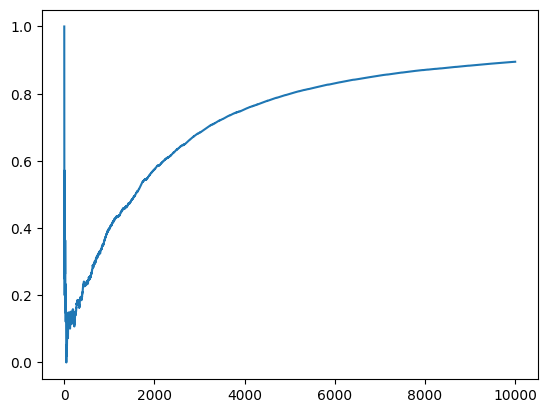

In [ ]:
plt.plot(episodes, scores_avg)